In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
from r2vm_functions import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#graph varaible
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=28)    # legend fontsize
plt.rc('font', size=30)          # controls default text sizes
sns.set(font_scale=2)
sns.set_style('white') # darkgrid, white grid, dark, white and ticks

In [ ]:
### Stimulus parameters

coh         = 8. # Motion coherence (positive sign is toward RF of pop1) [%]
mu0         = 30.0 # Zero motion coherence stimulus strength
noise_amp   = 0.05 # Noise amplitude into selective populations
N_trials    = 10 # Total number of trials
Tstim       = 600 # Time of stimulus onset [ms]
Tdur        = 1500 # Duration of stimulus [ms]

### Network parameters

JN11 = 0.2609 # self-excitation
JN22 = 0.2609 # self-excitation
JN12 = -0.0497 # cross-inhibition
JN21 = -0.0497 # cross-inhibition

Ib1 = 0.3255 # background current
Ib2 = 0.3255 # background current

### Synaptic time and other constants

Tnmda       = 100   # NMDA decay time constant
Tampa       = 2      # AMPA decay time constant
gamma       = 0.641 # Parameter that relates presynaptic input firing rate to synaptic gating variable
JAext       = 0.00052 # Synaptic coupling constant to external inputs

### F-I curve parameters
a = 270
b = 108
d = 0.1540

### Time conditions
dt         = 0.5 # Time step (ms)
time_wind  = 10#5/0.5 # Temporal window size for averaging
T_total    = int(5000/dt + time_wind) # Total number of steps

slide_wind = 40#20/dt # Sliding step for window

# Make lists to store firing rate (r) and gating variable (s)
r1_traj = [];  r2_traj = []; r3_traj = []; rI_traj = []
s1_traj = [];  s2_traj = []; s3_traj = []; sI_traj = []

for i in range(N_trials): #Loop through trials

    #print("trial # ", i)

    #Set random seed
    np.random.seed(i)

    #Initialize
    nu1_wind = [] ; nu2_wind = [] ;
    s1_wind  = [] ; s2_wind  = [] ;

    cross_r1 = []; cross_r2 = [];

    s1_in=0.1
    s2_in=0.1
    nu1_in = 2
    nu2_in = 2
    I_eta1_in = noise_amp*np.random.randn()
    I_eta2_in = noise_amp*np.random.randn()

    s1 = s1_in*np.ones(T_total)
    s2 = s2_in*np.ones(T_total)
    nu1 = nu1_in*np.ones(T_total)
    nu2 = nu2_in*np.ones(T_total)
    phi1 = nu1_in*np.ones(T_total)
    phi2 = nu2_in*np.ones(T_total)
    I_eta1 = I_eta1_in*np.ones(T_total)
    I_eta2 = I_eta2_in*np.ones(T_total)

    Isyn1 = np.zeros(T_total)
    Isyn2 = np.zeros(T_total)

    for t in range(0,T_total-1): #Loop through time for a trial

        #---- Random dot stimulus------------------------------------------------------

        I_stim_1 = (Tstim/dt<t & t<(Tstim+Tdur)/dt)*(JAext*mu0*(1+coh/100)); # To population 1
        I_stim_2 = (Tstim/dt<t & t<(Tstim+Tdur)/dt)*(JAext*mu0*(1-coh/100)); # To population 2

        #---- Resonse function of competiting excitatory population 1 ------

        # Total synaptic input to population 1
        Isyn1[t] = JN11*s1[t] + JN12*s2[t] + I_stim_1 + I_eta1[t];

        # Transfer function of population 1
        phi1[t]  = (a*Isyn1[t]-b)/(1-np.exp(-d*(a*Isyn1[t]-b)));

        #---- Response function of competiting excitatory population 2 -----

        # Total synaptic input to population 2
        Isyn2[t] = JN22*s2[t] + JN21*s1[t] + I_stim_2 + I_eta2[t];

        # Transfer function of population 2
        phi2[t]  = (a*Isyn2[t]-b)/(1-np.exp(-d*(a*Isyn2[t]-b)));

        #---- Dynamical equations -------------------------------------------

        # Mean NMDA-mediated synaptic dynamics updating
        s1[t+1] = s1[t] + dt*(-s1[t]/Tnmda + (1-s1[t])*gamma*nu1[t]/1000);
        s2[t+1] = s2[t] + dt*(-s2[t]/Tnmda + (1-s2[t])*gamma*nu2[t]/1000);

        # Ornstein-Uhlenbeck generation of noise in pop1 and 2
        I_eta1[t+1] = I_eta1[t] + (dt/Tampa)*(Ib1-I_eta1[t]) + np.sqrt(dt/Tampa)*noise_amp*np.random.randn() ;
        I_eta2[t+1] = I_eta2[t] + (dt/Tampa)*(Ib2-I_eta2[t]) + np.sqrt(dt/Tampa)*noise_amp*np.random.randn() ;

        # To ensure firing rates are always positive. Large noise amplitude
        # may result in unwanted negative values
        if phi1[t] < 0:
            nu1[t+1] = 0
            phi1[t] = 0
        else:
            nu1[t+1] = phi1[t]
        if phi2[t] < 0:
            nu2[t+1] = 0
            phi2[t] = 0
        else:
            nu2[t+1] = phi2[t]

    # ---- Calculating the mean rates and gating variables with sliding window -----

    nu1_wind.append(np.mean(nu1[0:time_wind]))
    nu2_wind.append(np.mean(nu2[0:time_wind]))

    s1_wind.append(np.mean(s1[0:time_wind]))
    s2_wind.append(np.mean(s2[0:time_wind]))

    for j in range(int((T_total-time_wind)/slide_wind)):
        nu1_wind.append(np.mean(nu1[j*slide_wind:j*slide_wind+time_wind]))
        nu2_wind.append(np.mean(nu2[j*slide_wind:j*slide_wind+time_wind]))
        s1_wind.append(np.mean(s1[j*slide_wind:j*slide_wind+time_wind]))
        s2_wind.append(np.mean(s2[j*slide_wind:j*slide_wind+time_wind]))

    r1_traj.append(nu1_wind)
    r2_traj.append(nu2_wind)
    s1_traj.append(s1_wind)
    s2_traj.append(s2_wind)



#Plot a single trial
# n_plot = 1
# for w in range(min(n_plot,N_trials)):
#     plt.figure()
#     plt.xlim(0,2000)
#     plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),r1_traj[w],c='b')
#     plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),r2_traj[w],c='r')
# plt.xlim(0,2000)
# plt.xlabel('Time (ms)')
# plt.ylabel('Firing rate (Hz)')


In [ ]:
# Define a threshold
threshold = 17

# Use the function
avg_rt_corr, rts_corr,avg_rt_err, rts_err, choices = calculate_reaction_times_and_choices(r1_traj, r2_traj, threshold, dt, slide_wind)

plt.figure()
plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),(np.mean(r1_traj,axis=0)),c='b',alpha=1,linewidth=5)
plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),(np.mean(r2_traj,axis=0)),c='r',alpha=1,linewidth=5)

plt.xlim(0,2000)
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
# plt.set_figwidth(25)
# plt.set_figheight(10)
ax = plt.gca()
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
sns.despine(fig= None, ax=None, top=True, right=True,offset=None, trim=False)

print(f"Average Reaction Time: {avg_rt_corr} ms")
print(f"Choices: {np.mean(choices)}")

In [28]:
coherences=[0,4,8,16,32,64]
results=[]
[results.append(run_simulation(coherences[i],0.0375,30)) for i in range(len(coherences))]

[None, None, None, None, None, None]

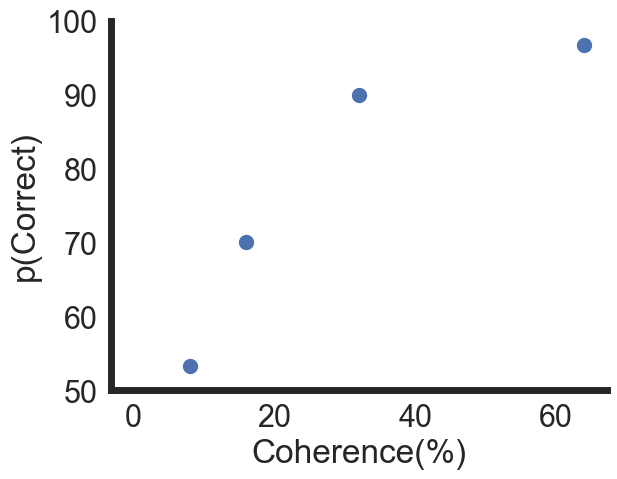

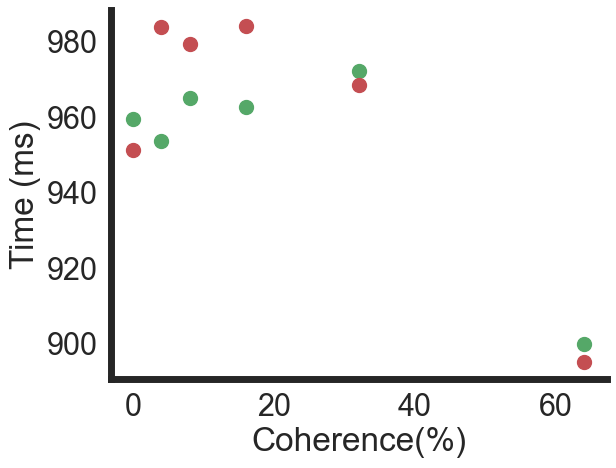

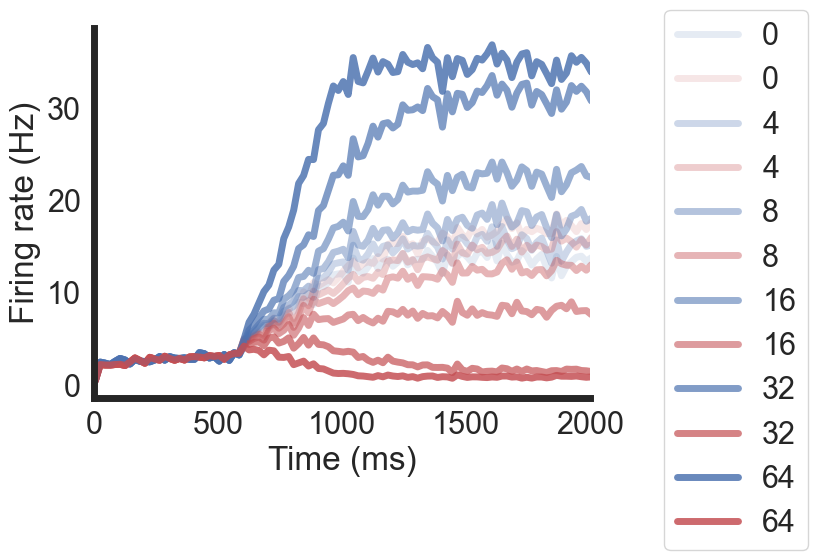

In [29]:
threshold = 12 #decision boundary
slide_wind=40 #window size
dt = 0.5 # Time step (ms)
time_wind = 10#5/0.5 # Temporal window size for averaging
T_total    = int(5000/dt + time_wind) # Total number of steps

all_rt_corr=[]
all_rt_err=[]
all_choices=[]
ave_fr_corr=[]
ave_fr_err=[]

# Use the function
for i in range(len(results)):
    avg_rt_corr, rts_corr,avg_rt_err, rts_err, choices = calculate_reaction_times_and_choices(results[i][0], results[i][1], threshold, dt, slide_wind)
    all_rt_corr.append(np.mean(rts_corr,axis=0))
    all_rt_err.append(np.mean(rts_err,axis=0))
    all_choices.append(np.mean(choices,axis=0)*100)
    ave_fr_corr.append(np.mean(results[i][0],axis=0))
    ave_fr_err.append(np.mean(results[i][1],axis=0))


plt.figure()
plt.scatter(coherences,all_choices,color='b',s=100)
ax = plt.gca()
plt.ylim(50,100)
plt.ylabel('p(Correct)')
plt.xlabel('Coherence(%)')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
sns.despine(fig= None, ax=None, top=True, right=True,offset=None, trim=False)

plt.figure()
plt.scatter(coherences,all_rt_corr,color='g',s=100)
plt.scatter(coherences,all_rt_err,color='r',s=100)
plt.ylabel('Time (ms)')
plt.xlabel('Coherence(%)')
ax = plt.gca()
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
sns.despine(fig= None, ax=None, top=True, right=True,offset=None, trim=False)

plt.figure()
for i in range(len(ave_fr_corr)):
    plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),(ave_fr_corr[i]),c='b',alpha=0.14*(i+1),label=coherences[i],linewidth=5)
    plt.plot(np.arange(dt*time_wind-dt*slide_wind,dt*T_total,dt*slide_wind),(ave_fr_err[i]),c='r',alpha=0.14*(i+1),label=coherences[i],linewidth=5)

plt.xlim(0,2000)
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.legend(bbox_to_anchor=(1.15, 1.05), loc='upper left', borderaxespad=0)

ax = plt.gca()
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
sns.despine(fig= None, ax=None, top=True, right=True,offset=None, trim=False)